In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 23.0MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 133kB 50.7MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 7.2MB 53.2MB/s 
ERROR: botocore 1.20.12 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [7]:
df = pd.read_csv('train.csv')

In [8]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df = df.drop(['keyword', 'location', 'id'], axis=1)

In [129]:
df.drop(7613)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7611,Police investigating after an e-bike collided ...,1
7612,The Latest: More Homes Razed by Northern Calif...,1
7643,"13,000\r\npeople\r\nreceive\r\n#wildfires\r\ne...",1
7670,#flood\r\n#disaster\r\nHeavy\r\nrain\r\ncauses...,1


In [10]:
df.dropna(subset = ["target"], inplace=True)

In [11]:
df['text'].isnull().value_counts()

False    7617
Name: text, dtype: int64

In [15]:
texts = df.text.values
texts = ["[CLS] " + str(text) + " [SEP]" for text in texts]
target = df.target.values

In [12]:
i = df[df['target'] == 'target'].index
print(i)

Int64Index([7613], dtype='int64')


In [13]:
df = df.drop(i)

In [14]:
len(df)

7616

In [16]:
target = target.astype(float).reshape(target.size,1)
target.dtype

dtype('float64')

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(text) for text in texts]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 14019649.30B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all', '[SEP]']


In [18]:
MAX_LEN = 128

In [19]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [20]:
len(input_ids[0])

16

In [21]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [22]:
len(input_ids[0])

128

In [23]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [141]:
# train_labels = np.asarray(train_labels)
print(train_labels.dtype)

object


In [24]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, target, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [25]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [26]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:05<00:00, 77237639.24B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [28]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [29]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [30]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.long()
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.long()
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.4545363912748736


Epoch:  25%|██▌       | 1/4 [03:04<09:14, 184.85s/it]

Validation Accuracy: 0.8416466346153846
Train loss: 0.3154214608114819


Epoch:  50%|█████     | 2/4 [06:11<06:10, 185.26s/it]

Validation Accuracy: 0.8377403846153846
Train loss: 0.20124700399505538


Epoch:  75%|███████▌  | 3/4 [09:17<03:05, 185.54s/it]

Validation Accuracy: 0.825020032051282
Train loss: 0.12483542819052589


Epoch: 100%|██████████| 4/4 [12:23<00:00, 185.82s/it]

Validation Accuracy: 0.8244190705128206


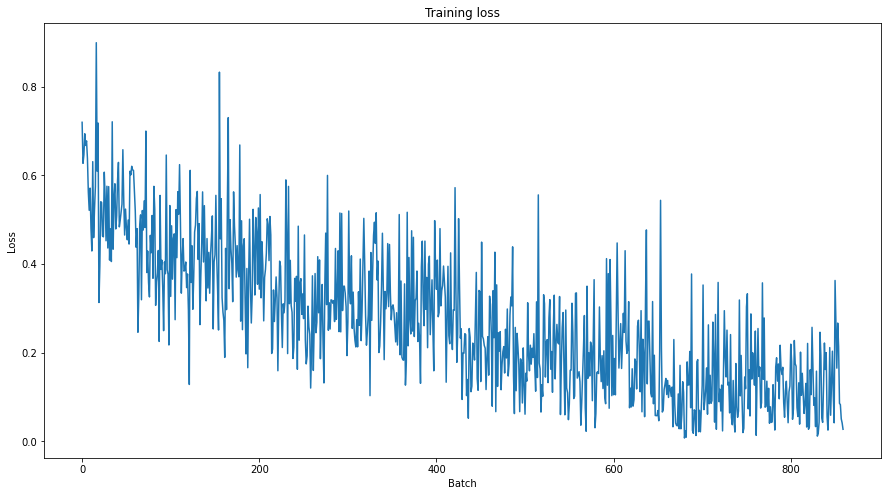

In [32]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [33]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [34]:
test_df = pd.read_csv('test.csv')

In [35]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
test_df = test_df.drop(['keyword', 'location', 'id'], axis=1)

In [37]:
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [50]:
# test_df['text'].isnull().value_counts()
# len(test_df['text'])

3263

In [58]:
texts = test_df.text.values
texts = ["[CLS] " + str(text) + " [SEP]" for text in texts]

In [59]:
len(texts)

3263

In [60]:
test_tokenized_texts = [tokenizer.tokenize(text) for text in texts]

In [61]:
len(test_tokenized_texts)

3263

In [62]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]

In [63]:
test_input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [64]:
len(test_input_ids)

3263

In [65]:
attention_masks = []

for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [66]:
prediction_inputs = torch.tensor(test_input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [67]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

31

In [89]:
output = []
for i in range(len(predictions)):
  for j in range(len(predictions[i])):
    if predictions[i][j][0] > predictions[i][j][1]:
      output.append(0)
    else:
      output.append(1)
len(output)

3263

In [82]:
# output

In [77]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [78]:
sample_submission = pd.read_csv('sample_submission.csv')

In [87]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [90]:
sample_submission['target'] = output

In [91]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [92]:
sample_submission.to_csv('submission_result.csv', index=False)